In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import itertools

from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [2]:
# Read Train Data
train_data = pd.read_csv("train_data.csv")
train_data['timestamp'] = pd.DatetimeIndex(train_data['timestamp'])

In [3]:
train_data.head(2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000


In [486]:
print(train_data.shape)

(30471, 292)


In [487]:
train_data.dtypes

id                             int64
timestamp             datetime64[ns]
full_sq                        int64
life_sq                      float64
floor                        float64
                           ...      
mosque_count_5000              int64
leisure_count_5000             int64
sport_count_5000               int64
market_count_5000              int64
price_doc                      int64
Length: 292, dtype: object

In [488]:
# Checking Missing Values
percent_missing = train_data.isnull().sum() * 100 / len(train_data)
counts_missing = train_data.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': train_data.columns, 'counts_missing': counts_missing, 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_df = missing_value_df.loc[missing_value_df['percent_missing'] > 0].sort_values(by = ['percent_missing'], ascending=False)
missing_values_columns = list(missing_value_df['column_name'].unique())
print("Total Columns With Missing Data:", missing_value_df.shape[0], "Columns")
missing_value_df

Total Columns With Missing Data: 51 Columns


,column_name,counts_missing,percent_missing
24,hospital_beds_raion,14441,47.392603
7,build_year,13605,44.649011
10,state,13559,44.498047
161,cafe_sum_500_max_price_avg,13281,43.585704
160,cafe_sum_500_min_price_avg,13281,43.585704
162,cafe_avg_price_500,13281,43.585704
5,max_floor,9572,31.413475
6,material,9572,31.413475
8,num_room,9572,31.413475
9,kitch_sq,9572,31.413475


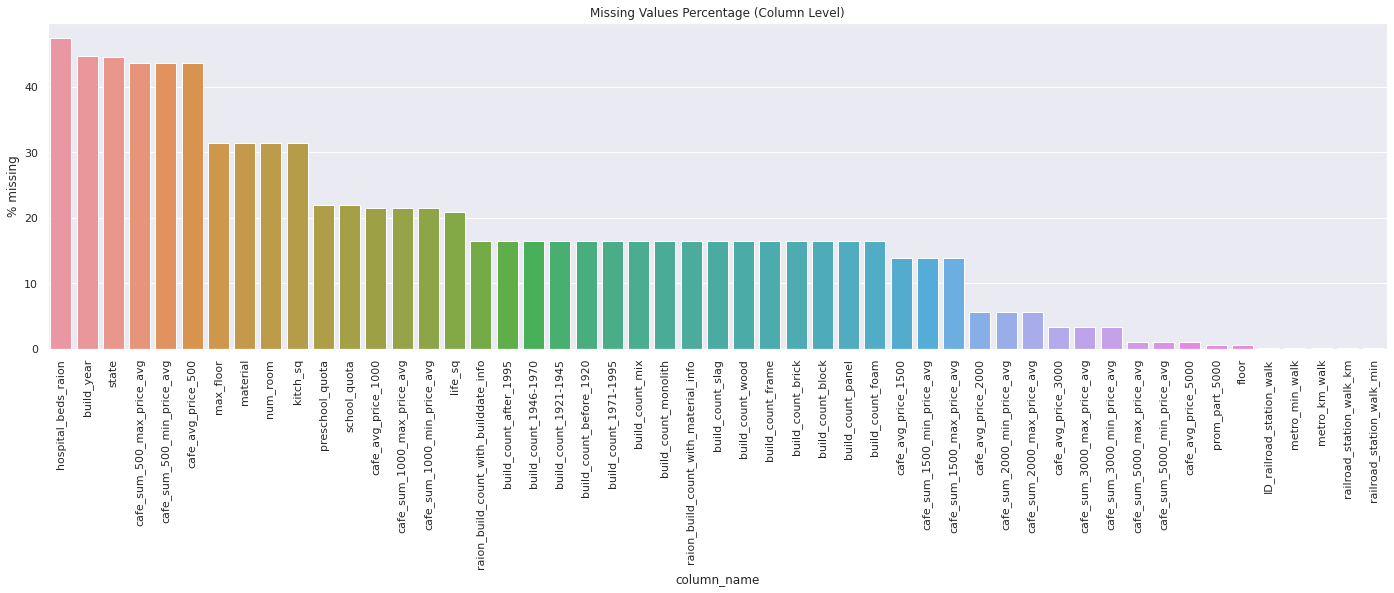

In [489]:
# Bar Plot For Missing Values 
f, ax = plt.subplots(figsize=(24, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_value_df.column_name, y=missing_value_df.percent_missing)
ax.set(title='Missing Values Percentage (Column Level)', ylabel='% missing')
plt.show()

Observations:
2. Total 51 Columns With Missing Values (Out Of 291)

In [490]:
# Check Unique Values With Each Column (We Can Remove If Any Column Contains Only One Unique Value)
unique_value_counts = pd.DataFrame(train_data.nunique()).reset_index()
unique_value_counts.columns = ['Column', 'UniqueCounts']
unique_value_counts.sort_values(by = ['UniqueCounts'])

,Column,UniqueCounts
241,mosque_count_2000,2
29,culture_objects_top_25,2
172,mosque_count_500,2
33,thermal_power_plant_raion,2
34,incineration_raion,2
...,...,...
146,church_synagogue_km,11852
147,mosque_km,11852
149,museum_km,11852
151,catering_km,11852


In [491]:
# Seperating Numerical and Categorical Columns List
numerical_columns = list(train_data.dtypes[train_data.dtypes != 'object'].index)
categorical_columns = list(train_data.dtypes[train_data.dtypes == 'object'].index)

In [492]:
# Features Related To Property
# full_sq: total area in square meters, including loggias, balconies and other non-residential areas
# life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
# floor: for apartments, floor of the building
# max_floor: number of floors in the building
# material: wall material
# build_year: year built
# num_room: number of living rooms
# kitch_sq: kitchen area
# state: apartment condition
# product_type: owner-occupier purchase or investment
# sub_area: name of the district

property_features = ['full_sq', 'life_sq', 'floor', 'max_floor','material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area']

property_features_categorical = []
property_features_numerical = []
for each_column in property_features:
    if train_data[each_column].dtype == 'object':
        property_features_categorical.append(each_column)
    else:
        property_features_numerical.append(each_column)
        
print("Categorical Columns: ", property_features_categorical)
print("Numerical Columns: ", property_features_numerical)

Categorical Columns:  ['product_type', 'sub_area']
Numerical Columns:  ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state']


Univariate Distribution (Property Related Features)

In [493]:

"""
dataframe_formatter function will be used for Formatting the Input DataFrame into Required Format For Bar Chart.
Parameter(s):
    ------------
        df : input_data
        column_name: column name
        threshold : Show Only Top Threshold Rows in Graph
Return(s):
    ---------
        Formatted DataFrame      
"""
def dataframe_formatter(input_df,column_name, threshold ):
    total_rows = input_df.shape[0]
    input_df = input_df.groupby(column_name).agg({column_name:"count"})
    input_df["total_sum"] = total_rows
    input_df["percentage"] = (input_df[column_name]/input_df["total_sum"])*100
    input_df["percentage"] = input_df["percentage"].apply(lambda x: round(x, 2))
    input_df = input_df.rename(columns={column_name:"individual_count"})
    input_df = input_df.sort_values(by = ['percentage'], ascending=False).head(threshold).reset_index()
    return input_df


"""
generate_bar_graph function will be useful for plotting the univariate bar chart distribution for every column.
Parameter(s):
    ------------
        column_name: column name Of the DataFrame For X Asis
        df_input : input_data
        ax_input: Input Axes
        title_input : Title to be shown When Graph is Visualized
Return(s):
    ---------
        print the barplot graph with the percentages.   
"""
def generate_bar_graph(column_name, ax_input, df_input, title_input):
    sns.barplot(x=column_name, y='percentage', data=df_input,  palette="mako", orient='v', \
        ax=ax_input, dodge=True,order=df_input[column_name])
    ax_input.set_title(title_input, fontsize=15, weight='bold')
    ax_input.set_xlabel ("Distribution of "+ column_name + " Variable")
    ax_input.set_ylabel ("Percentage Of "+ column_name + " Variable")
    ax_input.set_xticklabels(ax_input.get_xticklabels(), rotation=90, ha="center", fontsize = 12, weight='bold')


    # calculate the percentages and annotate the sns barplot
    for rect in ax_input.patches:
        x, y = rect.get_xy()
        ax_input.text(x+rect.get_width()/2, y+rect.get_height()*1.01, "%.1f%%"% rect.get_height(), weight='bold', ha='center')

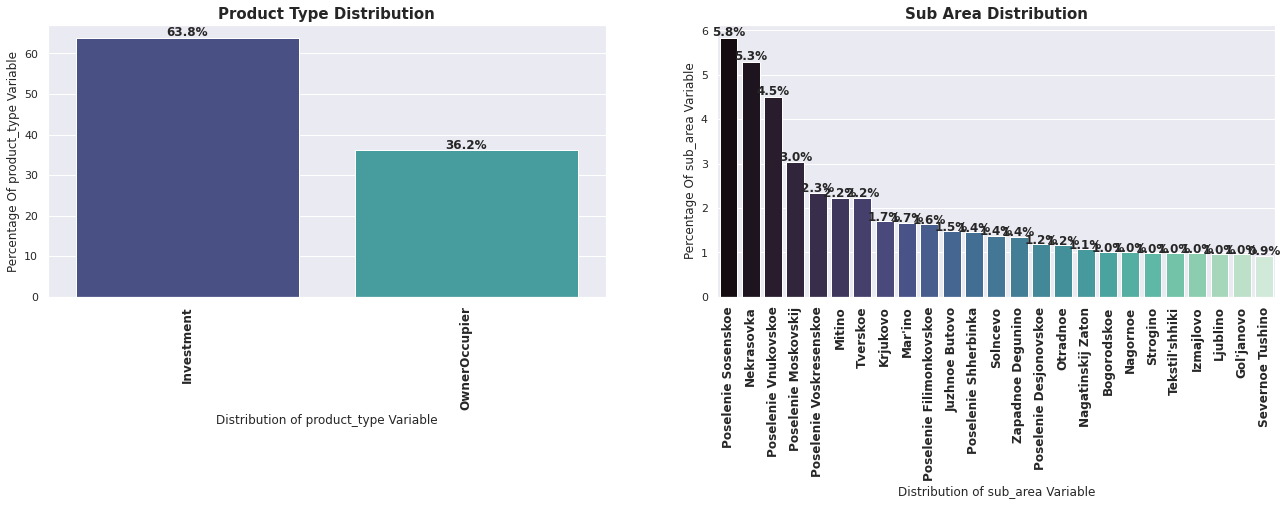

In [494]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(22,5))

# Product type Distribution
df_0 = dataframe_formatter(train_data, 'product_type', 10 )
generate_bar_graph('product_type', ax1, df_0, "Product Type Distribution")

# Sub Area Distribution
df_1 = dataframe_formatter(train_data,'sub_area', 25)
generate_bar_graph('sub_area', ax2, df_1,  "Sub Area Distribution")

In [495]:
train_data[property_features_numerical].describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state
count,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000
mean,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025
std,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000
50%,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000
75%,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000
max,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000


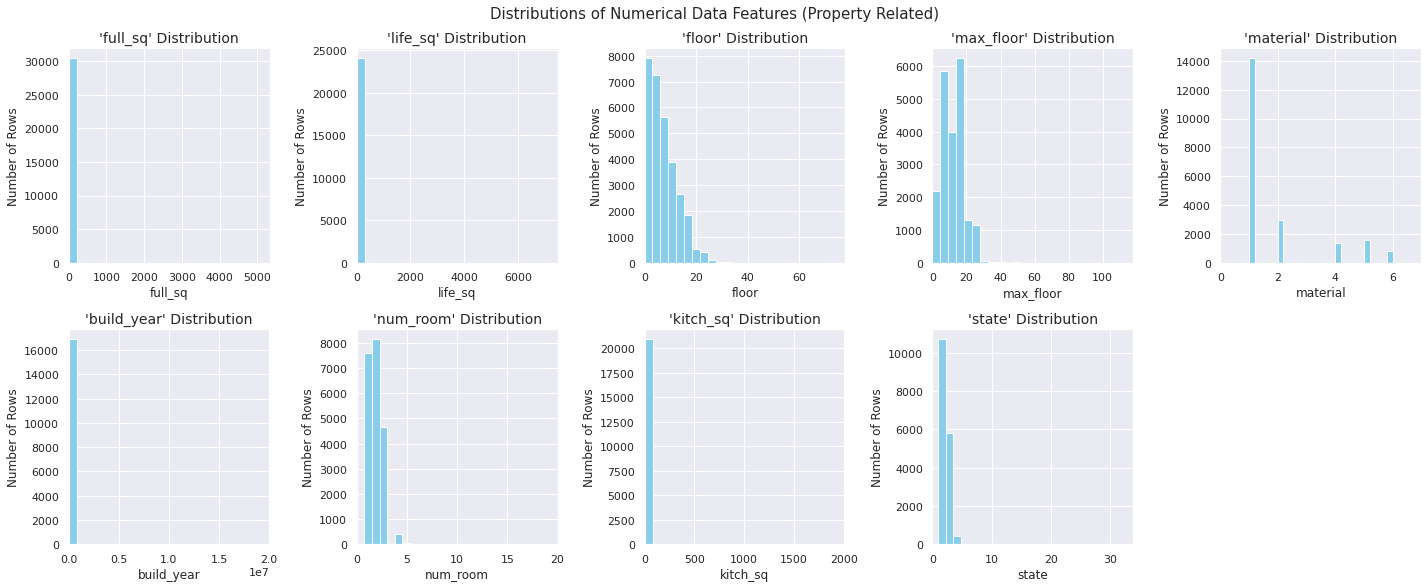

In [496]:
# Distribution Of Numerical Variables
fig = plt.figure(figsize = (20,8))

# Plotting Each Continuous Variable
for i, feature in enumerate(train_data[property_features_numerical]):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(train_data[feature], bins = 25, color = 'skyblue')
    ax.set_title("'%s'"%(feature) + " Distribution", fontsize = 14)
    ax.set_xlim((0, train_data[feature].max()+1))
    ax.set_xlabel(feature)
    ax.set_ylabel("Number of Rows")

fig.suptitle("Distributions of Numerical Data Features (Property Related)", fontsize = 15, y = 1.02)

fig.tight_layout()
fig.show()

Observation:
1. We Can See that All the Columns Are Right Skewed

In [497]:
sns.set(style="darkgrid")

def boxplot(df,column_name,title):
    """
    This function will be useful for plotting the boxplot to check the outliers.
    Parameter(s):
        ------------
            df : input_df
            column_name :  name of the column to plot the boxplot
            title : Title for graph
            Return(s):
            ---------
                print the boxplot and statistical summary.  
    """
    plt.figure(figsize = (20,5))
    sns.boxplot(x=df[column_name])
    plt.title(title, fontsize = 12)
    plt.show()

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = (Q1 - 1.5 * IQR)
    upper_whisker = (Q3 + 1.5 * IQR)
    employed_max = df[column_name].max()

    print("Data points appear above the UPPER_WHISKER {} can be statistically considered as the Outliers.".format(upper_whisker))
    print("Data points appear Below the LOWER_WHISKER {} can be statistically considered as the Outliers.".format(lower_whisker))

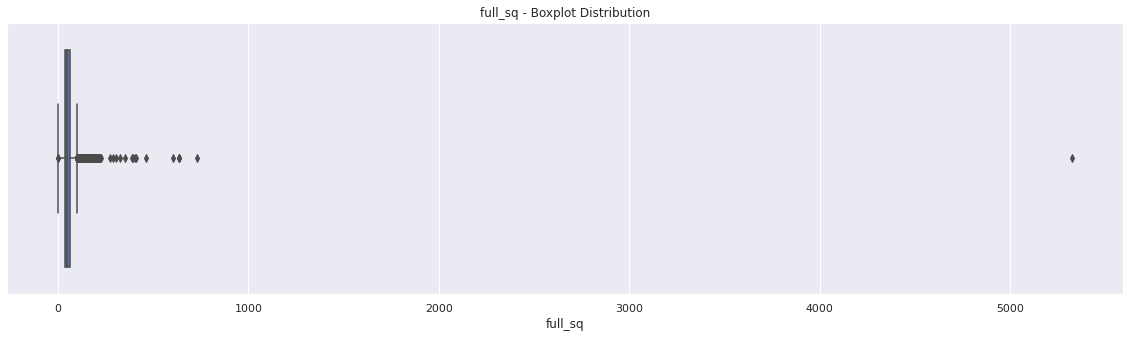

Data points appear above the UPPER_WHISKER 100.5 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER 0.5 can be statistically considered as the Outliers.


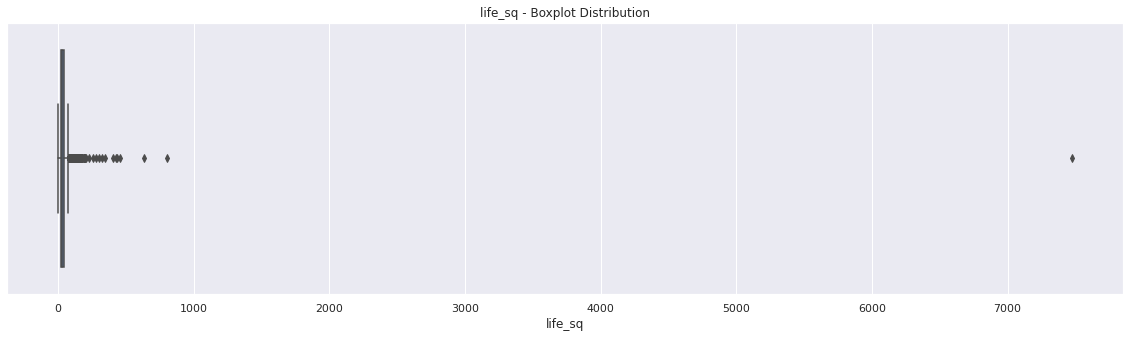

Data points appear above the UPPER_WHISKER 77.5 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER -14.5 can be statistically considered as the Outliers.


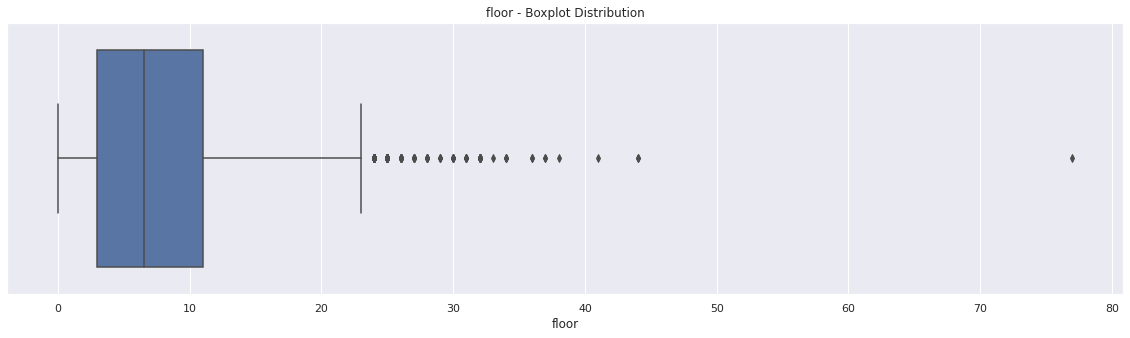

Data points appear above the UPPER_WHISKER 23.0 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER -9.0 can be statistically considered as the Outliers.


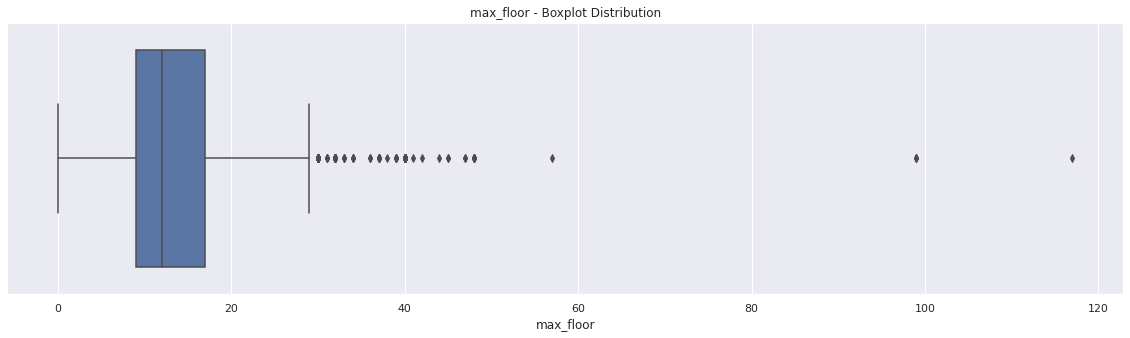

Data points appear above the UPPER_WHISKER 29.0 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER -3.0 can be statistically considered as the Outliers.


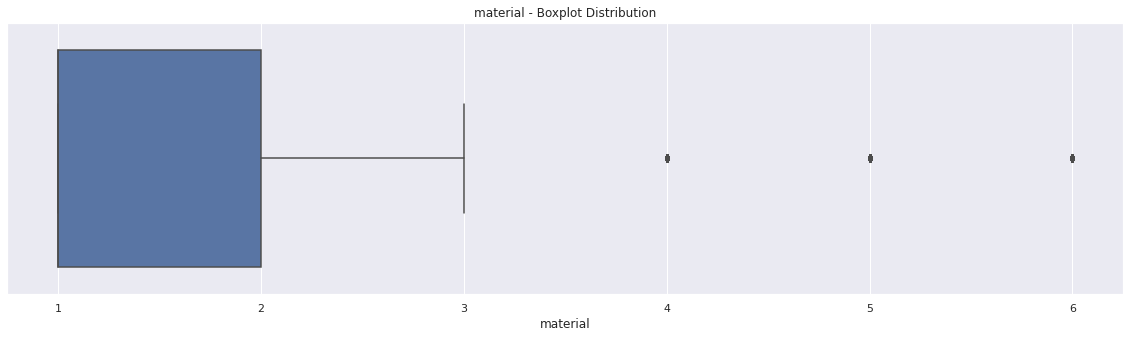

Data points appear above the UPPER_WHISKER 3.5 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER -0.5 can be statistically considered as the Outliers.


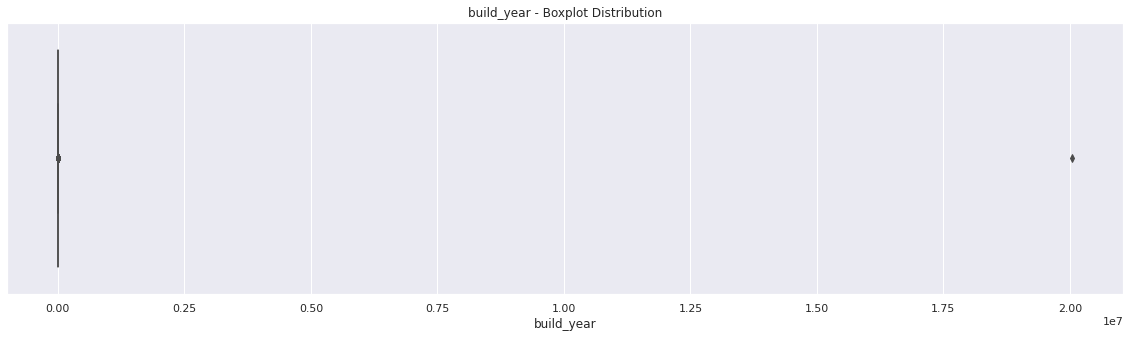

Data points appear above the UPPER_WHISKER 2062.0 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER 1910.0 can be statistically considered as the Outliers.


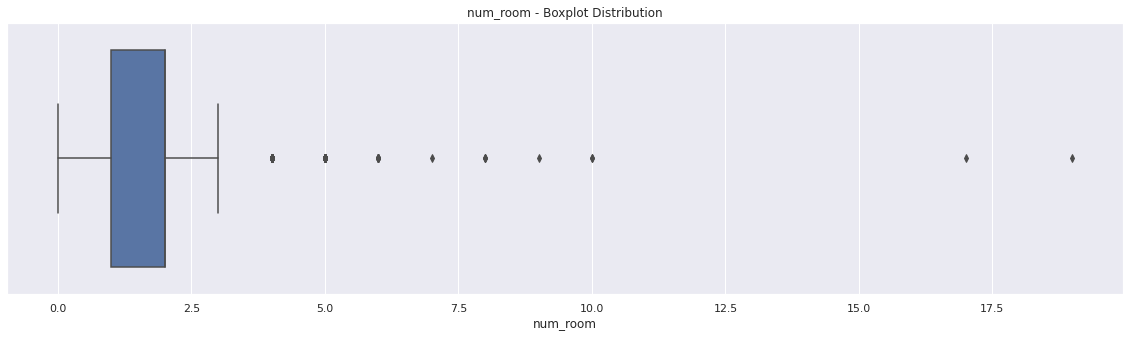

Data points appear above the UPPER_WHISKER 3.5 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER -0.5 can be statistically considered as the Outliers.


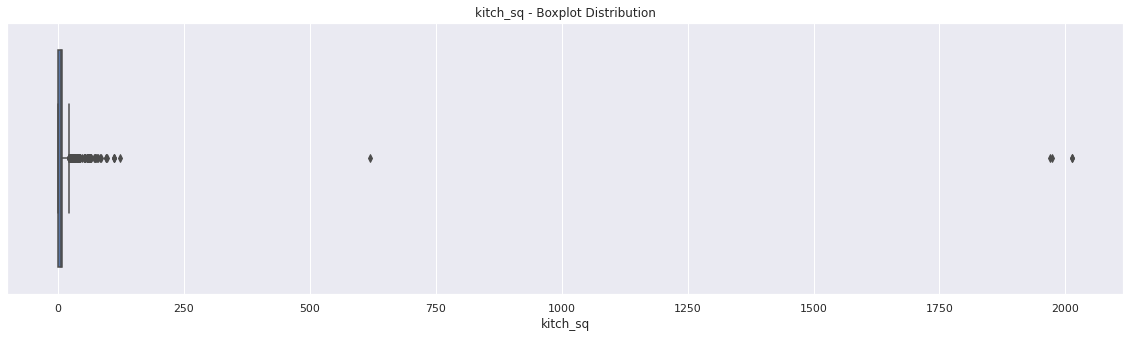

Data points appear above the UPPER_WHISKER 21.0 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER -11.0 can be statistically considered as the Outliers.


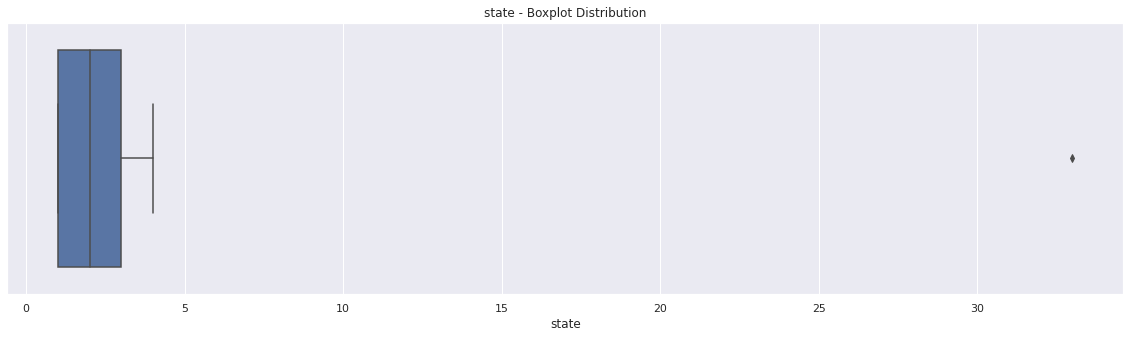

Data points appear above the UPPER_WHISKER 6.0 can be statistically considered as the Outliers.
Data points appear Below the LOWER_WHISKER -2.0 can be statistically considered as the Outliers.


In [498]:
# Boxplot Function Call For Property Related Features
for each_column in property_features_numerical:
    boxplot(train_data,each_column, each_column + " - Boxplot Distribution")

Observations 
We Can See that Few Points Are Too Far From the Other Data We Can Remove Those Data 
1. Full Sq (> 100.5)
2. life sq (> 77.5)
3. max_floor (> 29)
4. floor (> 23)
5. Kitch SQ ( > 21)
6. Num Rooms (3.5)
7. state ( > 6)

In [500]:
# Checking Shape Before Filtering the Outliers
train_data.shape

(30471, 292)

In [501]:
# Filtering the Dataframe based on barplot visual
train_data = \
    train_data.loc[~((train_data['full_sq'] > 100.5) | (train_data['life_sq'] > 77.5) | 
                     (train_data['max_floor'] > 29) | (train_data['floor'] > 23) | (train_data['kitch_sq'] >= 21) |
                    (train_data['num_room'] > 3.5) | (train_data['state'] > 6) | (train_data['build_year'] <=3))].reset_index(drop=True)

In [502]:
# Checking Shape After Filtering the Outliers
train_data.shape

(27721, 292)

Few Checks:
1. Build Year Should Not Be  Greater Than 2021
2. Full SQ Should be Greater Than or Equal to Life SQ
3. Floor Should Be Less than Or Equal to Max_Floor
4. Kitch Sq Should Not Be Greater Than full sq
5. Check If Less Than Four Digit Mentioned

In [503]:
# Check1 -> Year Greater Than Current Year
display(train_data.loc[train_data['build_year']>=2021])

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
14226,15223,2014-02-19,41,24.0,4.0,9.0,2.0,4965.0,2.0,5.0,3.0,Investment,Sokolinaja Gora,7905261.321,85956,0.014925,0.319809,4257,643.0,4,4756,5180.0,4,0,2857.0,5,1,14,4,no,0,8,16,no,no,no,yes,no,no,no,...,693.97,1176.72,935.34,5,35,41,25,13,2,0,12,19,0,5,55,3,21.93,17.85,145,2540660,55,1678421,363,674.12,1141.18,907.65,23,104,120,80,32,4,0,32,57,0,16,119,14,8400000


In [504]:
# The build year for id 15223 is 4965, which probably means that someone made a mistake of typing 4 instead of 1. 
train_data.loc[train_data['id'] == 15223, 'build_year'] = 1965

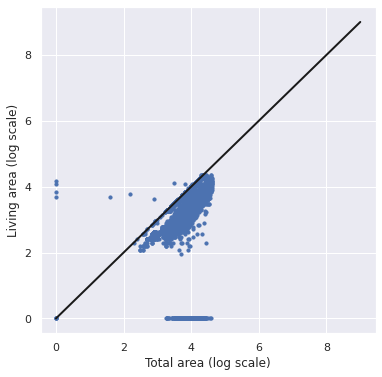

In [505]:
# Check 2 -> Scatter Plot Between Full SQ and Life SQ
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.scatter(x = np.log(train_data['full_sq']).values, y = np.log(train_data['life_sq'].values), s = 10, cmap = 'viridis')
plt.plot([0,9],[0,9],'k-', lw = 2)
plt.xlabel('Total area (log scale)')
plt.ylabel('Living area (log scale)')
plt.show()

Observation:
1. We Can See Few Rows Living Area/life sq is Greater than full_sq
2. Also Few Rows Where life_sq is 0 and full_sq is Available

In [506]:
# Replace Full SQ With Life SQ Where Full SQ is Smaller Than Life SQ
# train_data.loc[(train_data['full_sq']<train_data['life_sq']), 'full_sq'] = train_data.loc[(train_data['full_sq']<train_data['life_sq']), 'life_sq']

train_data.loc[(train_data['full_sq']<train_data['life_sq']), 'full_sq'] = \
train_data.loc[(train_data['full_sq']<train_data['life_sq']), 'life_sq'] + train_data.loc[(train_data['full_sq']<train_data['life_sq']), 'full_sq']

# Replace living area by total area if living area = 0:
train_data.loc[train_data['life_sq'].values == 0,'life_sq'] = train_data.loc[train_data['life_sq'].values == 0,'full_sq']

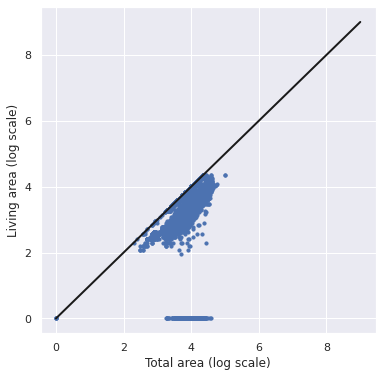

In [507]:
# Scatter Plot Between Full SQ and Life SQ (After Noise Cleaning)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.scatter(x = np.log(train_data['full_sq']).values, y = np.log(train_data['life_sq'].values), s = 10, cmap = 'viridis')
plt.plot([0,9],[0,9],'k-', lw = 2)
plt.xlabel('Total area (log scale)')
plt.ylabel('Living area (log scale)')
plt.show()

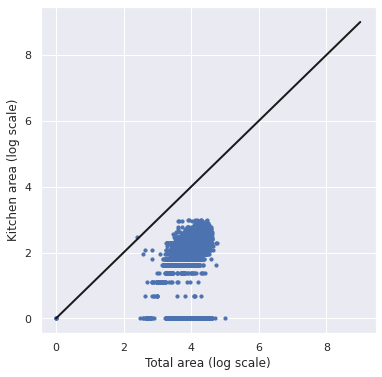

In [508]:
# Check 4 -> Scatter Plot Between Full SQ and Kitcher SQ
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.scatter(x = np.log(train_data['full_sq']).values, y = np.log(train_data['kitch_sq'].values), s = 10, cmap = 'viridis')
plt.plot([0,9],[0,9],'k-', lw = 2)
plt.xlabel('Total area (log scale)')
plt.ylabel('Kitchen area (log scale)')
plt.show()

In [509]:
# Add Kitchen SQ To Total SQ Where Values is Less Than Kitche SQ
train_data.loc[train_data['full_sq'] < train_data['kitch_sq'], 'full_sq'] = \
train_data.loc[train_data['full_sq'] < train_data['kitch_sq'], 'full_sq'] + train_data.loc[train_data['full_sq'] < train_data['kitch_sq'], 'kitch_sq']

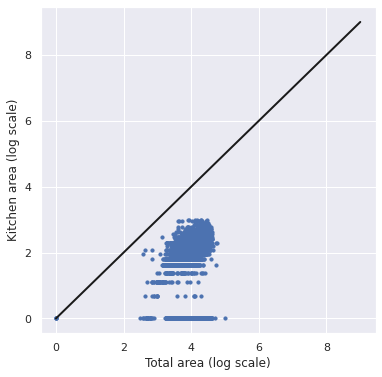

In [510]:
# Scatter Plot Between Full SQ and Kitchen SQ (After Modifications)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.scatter(x = np.log(train_data['full_sq']).values, y = np.log(train_data['kitch_sq'].values), s = 10, cmap = 'viridis')
plt.plot([0,9],[0,9],'k-', lw = 2)
plt.xlabel('Total area (log scale)')
plt.ylabel('Kitchen area (log scale)')
plt.show()

In [511]:
# Check 3 -> Replace Max Floor With Floor Where Floor is Greater Than Max Floor
train_data.loc[(train_data['floor']>train_data['max_floor']), 'max_floor'] = \
train_data.loc[(train_data['floor']>train_data['max_floor']), 'floor']

In [512]:
# Check 5 -> Build Year With Less Than Four Digit Column
train_data.loc[(train_data['build_year'] < 1000) & (train_data['build_year'] > 9)]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
27558,30278,2015-06-16,35.0,20.0,4.0,12.0,1.0,71.0,1.0,9.0,2.0,Investment,Troickij okrug,16315230.22,39873,0.375974,0.075424,2870,NaN,0,3097,NaN,0,0,NaN,0,0,3,2,no,0,0,0,no,no,no,no,no,no,no,...,1416.67,2333.33,1875.0,0,0,1,1,3,1,0,0,5,0,0,3,2,48.25,3.14,0,0,0,0,7,1285.71,2142.86,1714.29,0,0,2,1,3,1,0,0,6,0,0,3,2,4200000


In [513]:
# Replace 71 With 1971
train_data.loc[train_data['build_year'] == 71, 'build_year'] = 1971

Distributuion Of Target Variable

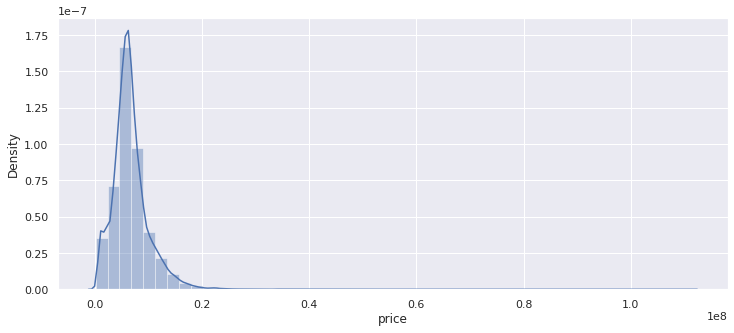

In [514]:
# Target Variable Distribution
plt.figure(figsize=(12,5))
sns.distplot(train_data.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

Observation:
1. We Can see that Data is Right Skewed and Very Long Tail

In [515]:
# Check Null Values Percentage Again (As We Removed Few Rows)
percent_missing = train_data.isnull().sum() * 100 / len(train_data)
counts_missing = train_data.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': train_data.columns, 'counts_missing': counts_missing, 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_df = missing_value_df.loc[missing_value_df['percent_missing'] > 0].sort_values(by = ['percent_missing'], ascending=False)
missing_values_columns = list(missing_value_df['column_name'].unique())
print("Total Columns With Missing Data:", missing_value_df.shape[0], "Columns")

Total Columns With Missing Data: 51 Columns


In [516]:
# Missing Values Fill For Property Related Columns
missing_values_columns_copy = missing_values_columns.copy()
for each_column  in missing_values_columns_copy:
    if each_column in property_features:
        train_data[each_column] = train_data[each_column].fillna(train_data[each_column].median())
        missing_values_columns.remove(each_column)

In [517]:
# Missing Values Fill For Other  Columns
missing_values_columns_copy = missing_values_columns.copy()
for each_column  in missing_values_columns_copy:
  train_data[each_column] = train_data[each_column].fillna(train_data[each_column].median())
  missing_values_columns.remove(each_column)

In [518]:
# Check Null Values Percentage Again (Complete Null Values Fill is Done)
percent_missing = train_data.isnull().sum() * 100 / len(train_data)
counts_missing = train_data.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': train_data.columns, 'counts_missing': counts_missing, 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_df = missing_value_df.loc[missing_value_df['percent_missing'] > 0].sort_values(by = ['percent_missing'], ascending=False)
missing_values_columns = list(missing_value_df['column_name'].unique())
print("Total Columns With Missing Data:", missing_value_df.shape[0], "Columns")

Total Columns With Missing Data: 0 Columns


In [519]:
# Label Enccoding For Categorical Variables
for f in train_data.columns:
    if train_data[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_data[f].values)) 
        train_data[f] = lbl.transform(list(train_data[f].values))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106]), <a list of 107 Text major ticklabel objects>)

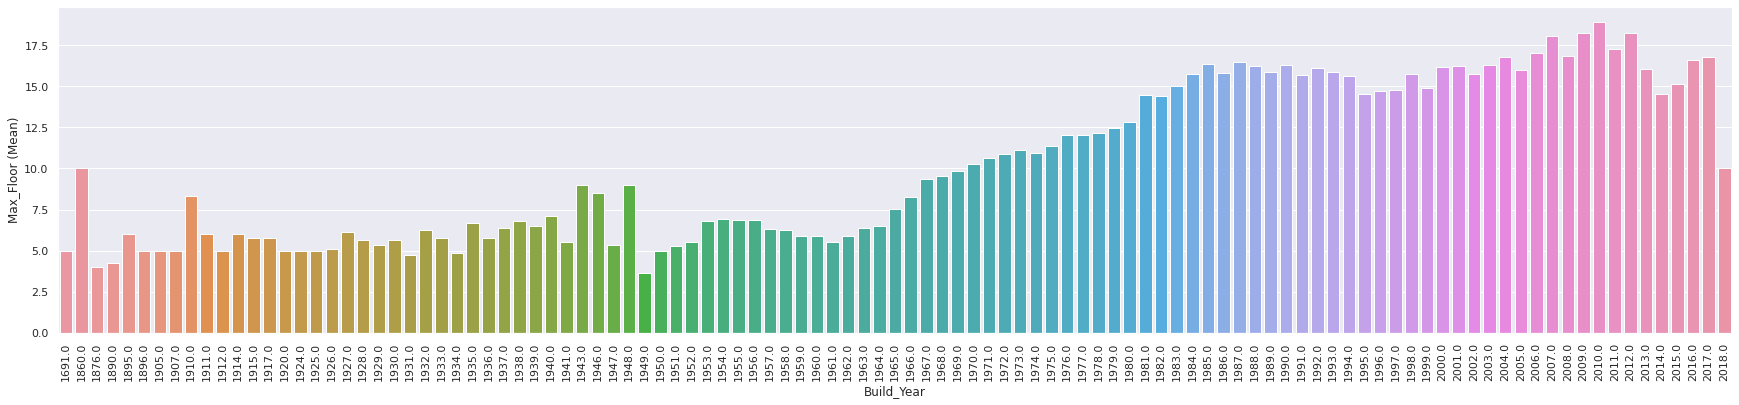

In [522]:
# Build Year Vs Average Max Floor
grouped_df = train_data.groupby('build_year')['max_floor'].aggregate(np.mean).reset_index()
fig, ax = plt.subplots(figsize=(30,6))
sns.barplot(grouped_df['build_year'], grouped_df['max_floor'])
plt.ylabel('Max_Floor (Mean)', fontsize=12)
plt.xlabel('Build_Year', fontsize=12)
plt.xticks(rotation='vertical')

Observation:


1.   We Can Observe that at the early level build years Average Max Floor is Fluctuating
2.   End Part of the Visual we can see that as the build year increasing max floors increasing



(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106]), <a list of 107 Text major ticklabel objects>)

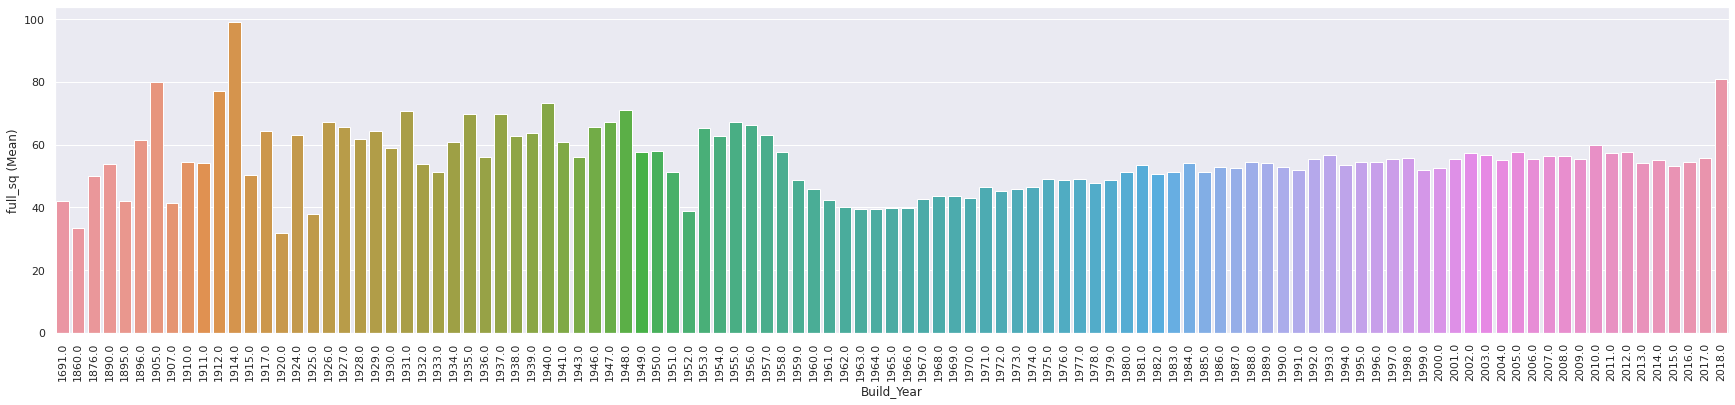

In [523]:
# Build Year Vs Average Max Floor
grouped_df = train_data.groupby('build_year')['full_sq'].aggregate(np.mean).reset_index()
fig, ax = plt.subplots(figsize=(30,6))
sns.barplot(grouped_df['build_year'], grouped_df['full_sq'])
plt.ylabel('full_sq (Mean)', fontsize=12)
plt.xlabel('Build_Year', fontsize=12)
plt.xticks(rotation='vertical')

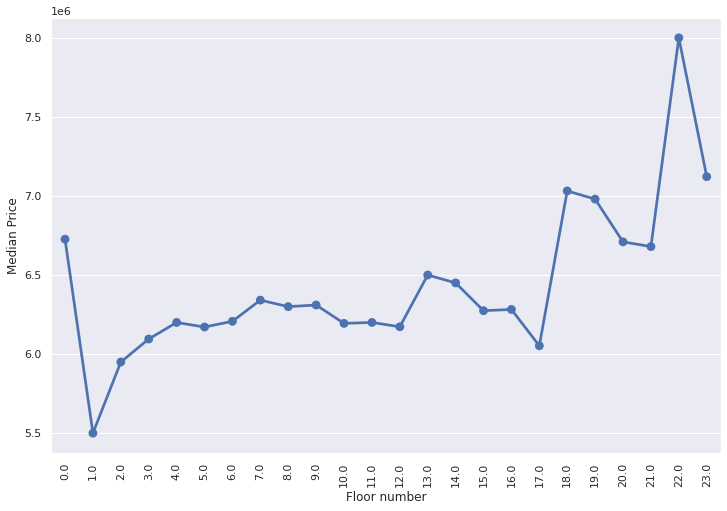

In [524]:
grouped_df = train_data.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Observation:
1. Mean Increasing as Floor is Increased
2. Price Of Independent houses is also higher we can see at the start of visual
3. Big Increase in the Price Betweemn 16 and 18 Floors

In [525]:
# Calculate Correlation Between Different Columns and Drop Feeatures With Correlation More than 0.85 (Higly Correlated)
corr = train_data.drop(columns = ['id','timestamp', 'price_doc']).corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.85:
            if columns[j]:
                columns[j] = False
selected_columns = train_data.drop(columns = ['id','timestamp', 'price_doc']).columns[columns]
train_data = train_data[list(selected_columns)+['id','timestamp', 'price_doc']]

In [526]:
# Checking Number of COlumns After Previous Step
train_data.shape

(27721, 128)

In [527]:
# Using Random Forest To Get Top N Features
data_x = train_data.copy()
data_x = data_x.drop(columns = ['id','timestamp', 'price_doc'])
data_y = train_data[['price_doc']].copy()

rf = RandomForestRegressor(random_state=0)
rf = rf.fit(data_x, data_y)

In [528]:
# Creating a DataFrame For Feature Importance (Top 100 Features)
fi = list(zip(data_x.columns, rf.feature_importances_))
features_importance = pd.DataFrame(fi, columns = ['Feature','Score']).sort_values(by = ['Score'], ascending=False).head(100)

In [529]:
features_importance

,Feature,Score
0,full_sq,0.293959
73,nuclear_reactor_km,0.101115
62,ttk_km,0.053723
12,raion_popul,0.025512
2,floor,0.016209
...,...,...
65,big_road1_1line,0.001007
22,additional_education_raion,0.000874
108,market_count_1000,0.000766
24,culture_objects_top_25_raion,0.000763


In [530]:
# Creating a List For Top 100 Important Featues
important_features = list(features_importance['Feature'])

In [531]:
# Checking the Correlation between Featues
# As We Cannot Compare All the Features Single Time (We Can Divide Them Into Groups )
# Groups Like -> Property Related Features, School Related Features, Cafe Related Features, near by
school_features = [each for each in important_features if ('school' in each) or ('education' in each) or ('kindergarten' in each) or ('university' in each)]
cafe_features = [each for each in important_features if 'cafe' in each]
property_top_features = [each for each in important_features if each in property_features]
other_feartures = [each for each in important_features if (each not in property_top_features) & (each not in school_features) & (each not in cafe_features)]
near_by_features = [each for each in other_feartures if ('km' in each) or ('mins' in each)]
other_feartures = [each for each in important_features if (each not in property_top_features) & (each not in school_features) & \
                   (each not in cafe_features) & (each not in near_by_features)]

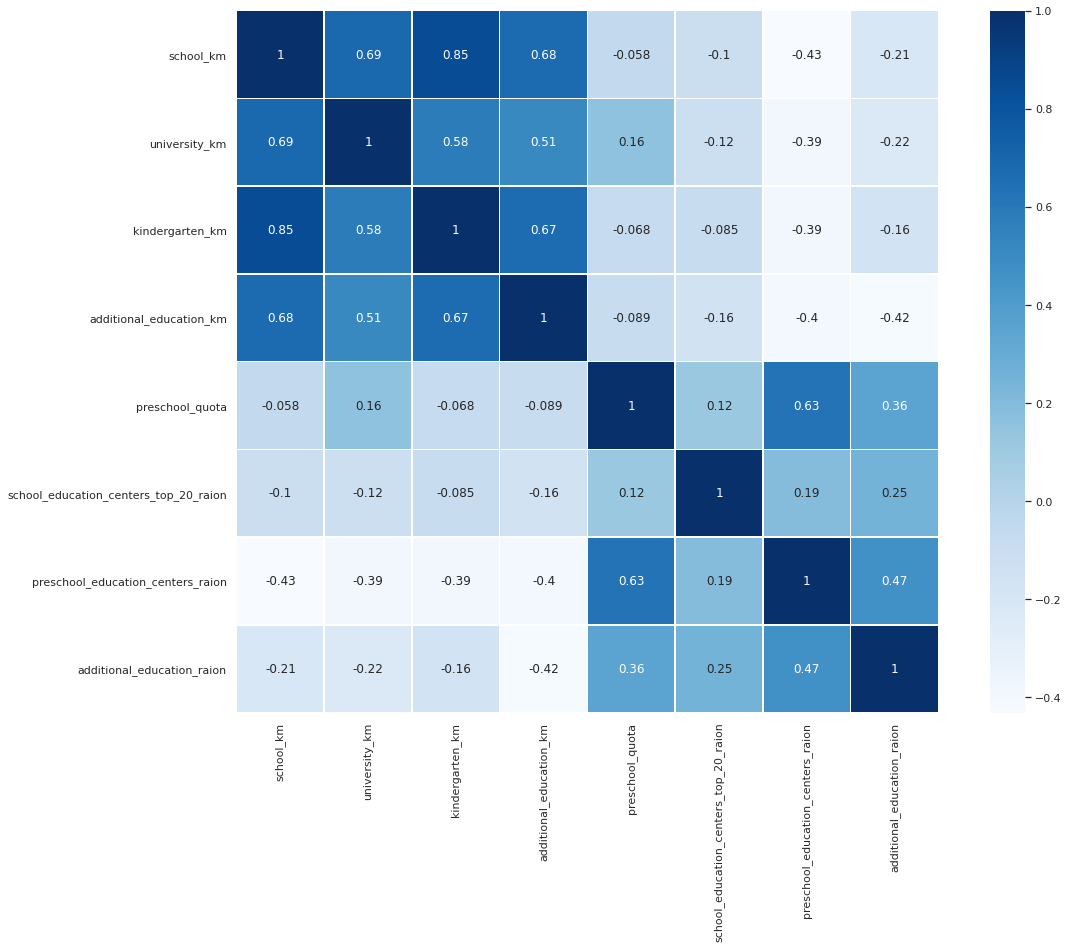

In [532]:
# School Features Heat Map
plt.subplots(figsize=(18, 15))
sns.heatmap(train_data[school_features].corr(), square=True, linewidths=.5, annot=True,cmap="Blues")
plt.xticks(rotation='90')
plt.yticks(rotation='0')
plt.subplots_adjust(top = 0.95, bottom = 0.3, left = 0.2, right = 1)
plt.show()

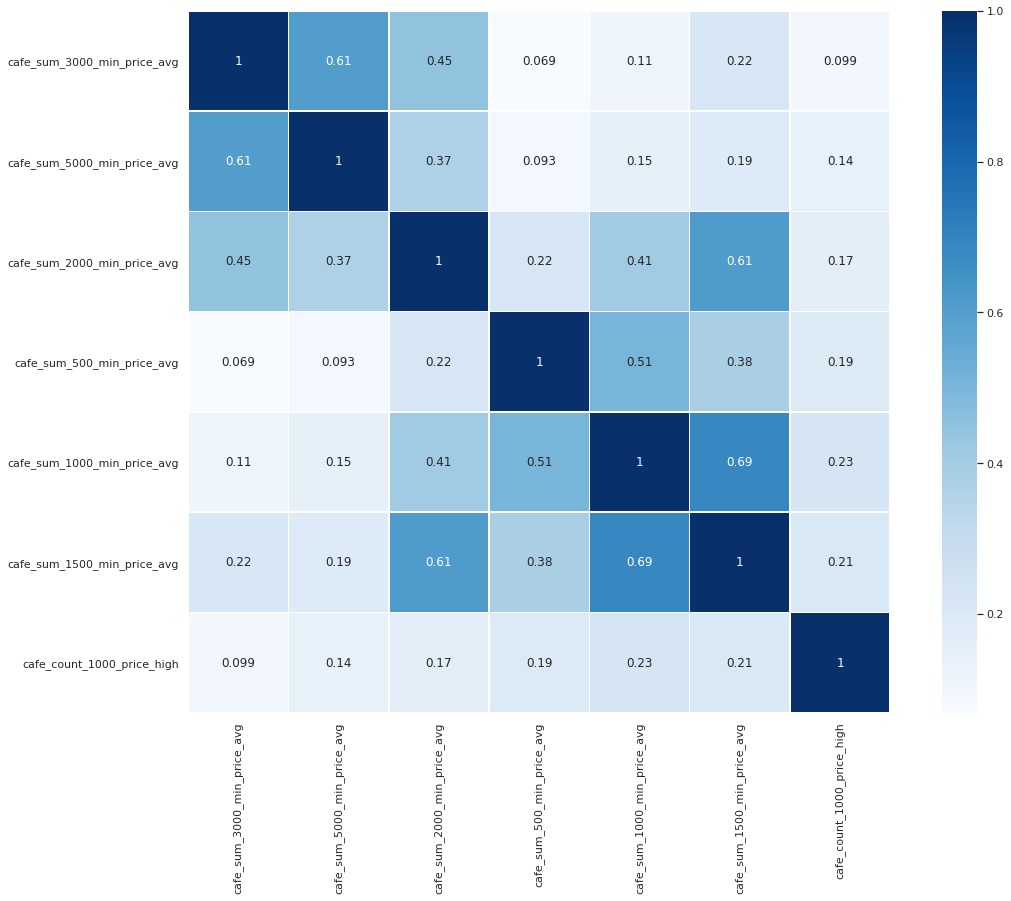

In [533]:
# Cafe Features Heat Map
plt.subplots(figsize=(18, 15))
sns.heatmap(train_data[cafe_features].corr(), square=True, linewidths=.5, annot=True, cmap="Blues")
plt.xticks(rotation='90')
plt.yticks(rotation='0')
plt.subplots_adjust(top = 0.95, bottom = 0.3, left = 0.2, right = 1)
plt.show()

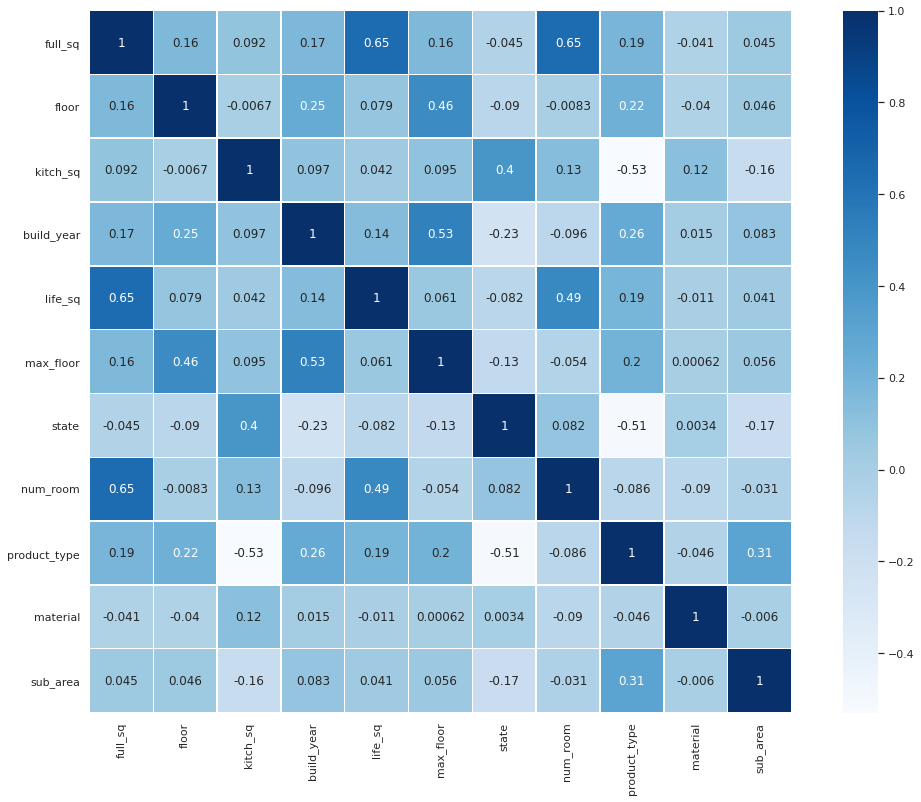

In [534]:
# Property Features Heat Map
plt.subplots(figsize=(18, 15))
sns.heatmap(train_data[property_top_features].corr(), square=True, linewidths=.5, annot=True, cmap = 'Blues')
plt.xticks(rotation='90')
plt.yticks(rotation='0')
plt.subplots_adjust(top = 0.95, bottom = 0.3, left = 0.2, right = 1)
plt.show()

In [535]:
# Near By Features (As There are Many Features Filtering the Total Combinations Where Correlation is Greater Than 0.75)
correlation = train_data[near_by_features].corr().reset_index()
cols_list = list(correlation.columns)
cols_list.remove('index')
correlation = pd.melt(correlation, id_vars=['index'], value_vars= cols_list)
correlation = correlation.loc[(correlation['index'] != correlation['variable']) & (correlation['value'] >= 0.75)]
# correlation = correlation[pd.DataFrame(np.sort(correlation[['index','variable']].values,1)).duplicated().values]
filtered_columns_near_by = list(correlation['index'].unique())

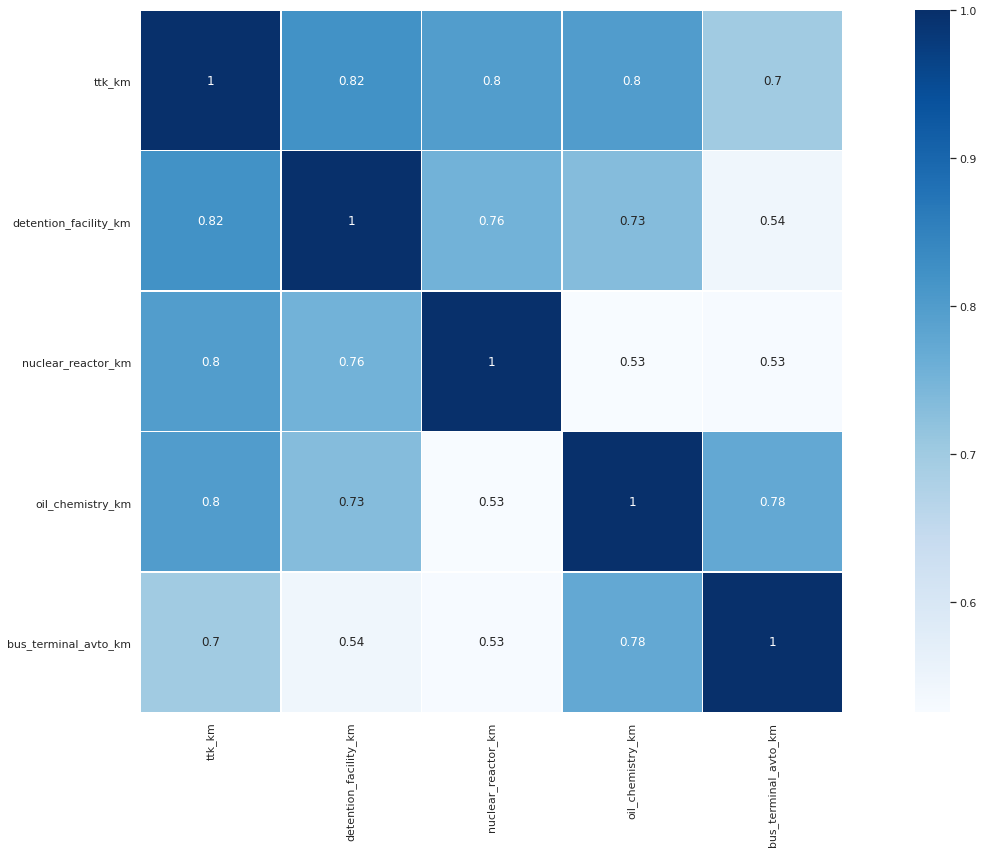

In [536]:
# Near By Features Heat Map
plt.subplots(figsize=(25, 15))
sns.heatmap(train_data[filtered_columns_near_by].corr(), square=True, linewidths=.5, annot=True, cmap = 'Blues')
plt.xticks(rotation='90')
plt.yticks(rotation='0')
plt.subplots_adjust(top = 0.95, bottom = 0.3, left = 0.2, right = 1)
plt.show()

In [537]:
# Drop Extreme Values (Less Than 1 percentile and Greater Than 99 Percentile)
train_data = train_data.loc[~(train_data['price_doc'] < train_data['price_doc'].quantile(0.01)) | ~(train_data['price_doc'] > train_data['price_doc'].quantile(0.99))].reset_index(drop=True)

In [538]:
# Normalize Target Variable (Considering RMSLE As Metric Log Normallization Helps)
train_data['price_doc'] = np.log(train_data.price_doc.values+1)

In [539]:
# Drop Id and TimeStamp Column
train_data_lr = train_data.drop(columns = ['id', 'timestamp'])

In [540]:
train_data_lr_features = train_data_lr.drop(columns = ['price_doc'])
train_data_lr_target = train_data_lr[['price_doc']]

In [541]:
# Label Encoding For Categorical Features
for f in train_data_lr.columns:
    if train_data_lr[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_data_lr[f].values)) 
        train_data_lr[f] = lbl.transform(list(train_data_lr[f].values))

In [542]:
# Train Test Split 
X_train, X_test, Y_train, Y_test = train_test_split(train_data_lr_features, train_data_lr_target, test_size=0.2, random_state = 42)

In [543]:
# Logistic Regression Metrics Fit
Model_1_Logistic = LinearRegression(fit_intercept=True, normalize=True)
Model_1_Logistic.fit(X_train, Y_train)
lr_pred_test = Model_1_Logistic.predict(X_test)
lr_pred_train = Model_1_Logistic.predict(X_train)

In [544]:
# Different Metrics For LR Model
print("*"*20," Train ", "*"*20)
print('Mean Absolute error (LR - Train): ', mean_absolute_error(Y_train, lr_pred_train))
print('Mean squared error (LR - Train): ', mean_squared_error(Y_train, lr_pred_train))
print('Root Mean squared error (LR - Train): ', np.sqrt(mean_squared_error(Y_train, lr_pred_train)))
print('Root Mean squared Log error (LR - Train): ', np.sqrt(mean_squared_log_error(Y_train, lr_pred_train)))
print('R2 Score (LR - Train): ', r2_score(Y_train, lr_pred_train))

print("*"*20," Test ", "*"*20)
print('Mean Absolute error (LR - Test): ', mean_absolute_error(Y_test, lr_pred_test))
print('Mean squared error (LR - Test): ', mean_squared_error(Y_test, lr_pred_test))
print('Root Mean squared error (LR - Test): ', np.sqrt(mean_squared_error(Y_test, lr_pred_test)))
print('Root Mean squared Log error (LR - Test): ', np.sqrt(mean_squared_log_error(Y_test, lr_pred_test)))
print('R2 Score (LR - Test): ', r2_score(Y_test, lr_pred_test))

********************  Train  ********************
Mean Absolute error (LR - Train):  0.29704236161321357
Mean squared error (LR - Train):  0.22729051868845215
Root Mean squared error (LR - Train):  0.4767499540518616
Root Mean squared Log error (LR - Train):  0.02976187547103737
R2 Score (LR - Train):  0.3086849738949917
********************  Test  ********************
Mean Absolute error (LR - Test):  0.30317234847377755
Mean squared error (LR - Test):  0.24390390954245325
Root Mean squared error (LR - Test):  0.49386628710861935
Root Mean squared Log error (LR - Test):  0.03086270117961624
R2 Score (LR - Test):  0.2731811534900084


Observations -> Linear Regression
* Log Normalized the Target Variable

1. Basic Linear Regression model is used to build model
2. RMSLE = 0.0308 (Test)
3. Difference between RMSE (Train & Test) is low
4. We Can also Observe that difference between R2 Value for train and test is not much a difference

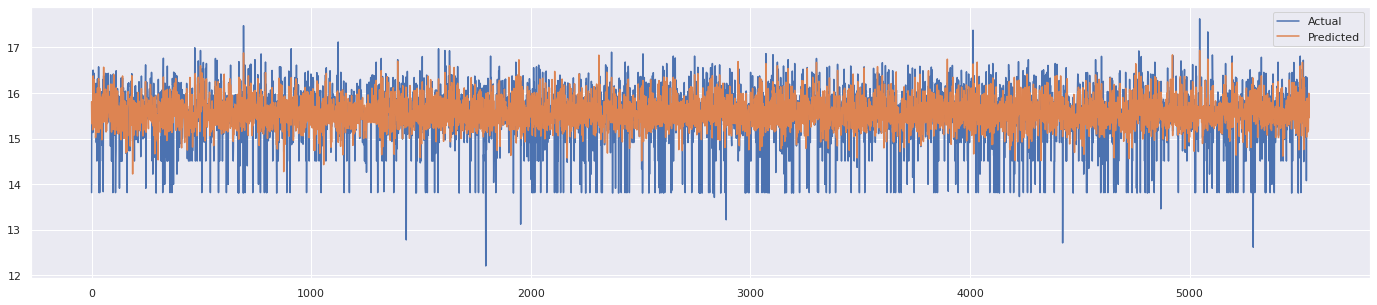

In [545]:
# Predicted Vs Actual (Time Series)
plt.figure(figsize=(24,5))
plt.plot(Y_test.reset_index().index, Y_test, label = "Actual")
plt.plot(Y_test.reset_index().index, lr_pred_test, label = "Predicted")
plt.legend()
plt.show()

In [546]:
# RandomForest Regressor Model Build
Model_2_Randomforest = RandomForestRegressor()
Model_2_Randomforest.fit(X_train, Y_train)
Y_pred_rf_test = Model_2_Randomforest.predict(X_test)
Y_pred_rf_train = Model_2_Randomforest.predict(X_train)

In [547]:
# Different Metrics For Random Forest Model
print("*"*20," Train ", "*"*20)
print('Mean Absolute error (RF - Train): ', mean_absolute_error(Y_train, Y_pred_rf_train))
print('Mean squared error (RF - Train): ', mean_squared_error(Y_train, Y_pred_rf_train))
print('Root Mean squared error (RF - Train): ', np.sqrt(mean_squared_error(Y_train, Y_pred_rf_train)))
print('Root Mean squared Log error (RF - Train): ', np.sqrt(mean_squared_log_error(Y_train, Y_pred_rf_train)))
print('R2 Score (RF - Train): ', r2_score(Y_train, Y_pred_rf_train))

print("*"*20," Test ", "*"*20)
print('Mean Absolute error (RF - Test): ', mean_absolute_error(Y_test, Y_pred_rf_test))
print('Mean squared error (RF - Test): ', mean_squared_error(Y_test, Y_pred_rf_test))
print('Root Mean squared error (RF - Test): ', np.sqrt(mean_squared_error(Y_test, Y_pred_rf_test)))
print('Root Mean squared Log error (RF - Test): ', np.sqrt(mean_squared_log_error(Y_test, Y_pred_rf_test)))
print('R2 Score (RF - Test): ', r2_score(Y_test, Y_pred_rf_test))

********************  Train  ********************
Mean Absolute error (RF - Train):  0.10575618791865914
Mean squared error (RF - Train):  0.03300573227009529
Root Mean squared error (RF - Train):  0.18167479811491546
Root Mean squared Log error (RF - Train):  0.011536294977092089
R2 Score (RF - Train):  0.8996114805070613
********************  Test  ********************
Mean Absolute error (RF - Test):  0.2883756947625856
Mean squared error (RF - Test):  0.25036412084466797
Root Mean squared error (RF - Test):  0.5003639883571438
Root Mean squared Log error (RF - Test):  0.03122460330217547
R2 Score (RF - Test):  0.2539301159166675


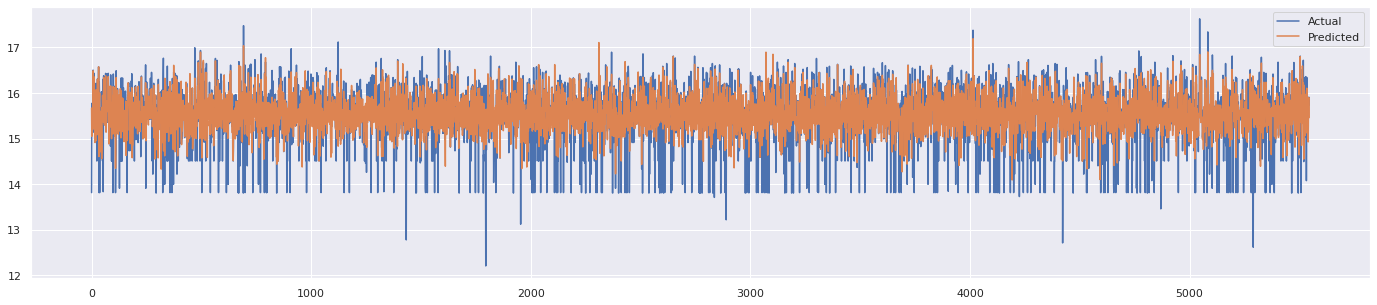

In [548]:
# Predicted Vs Actual (Time Series)
plt.figure(figsize=(24,5))
plt.plot(Y_test.reset_index().index, Y_test, label = "Actual")
plt.plot(Y_test.reset_index().index, Y_pred_rf_test, label = "Predicted")
plt.legend()
plt.show()

In [549]:
# Defining the possible values for each Parameter
# Random Forest Hyper Parameter Tuning
Model_3_Random_Hyperparameter = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Model_3_Random_Hyperparameter_fit = RandomizedSearchCV(estimator = Model_3_Random_Hyperparameter, param_distributions = random_grid, cv = 5, verbose=2, n_jobs = -1)
# Model_3_Random_Hyperparameter_fit = Model_3_Random_Hyperparameter_fit.fit(X_train, Y_train)

In [550]:
Model_3_Random_Hyperparameter_fit =  RandomForestRegressor(bootstrap= True,
 max_depth= 46,max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 10, n_estimators= 247)
Model_3_Random_Hyperparameter_fit = Model_3_Random_Hyperparameter_fit.fit(X_train, Y_train)

In [551]:
# Best Params
# Model_3_Random_Hyperparameter_fit.best_params_
# {'bootstrap': True,'max_depth': 46,'max_features': 'sqrt','min_samples_leaf': 1,'min_samples_split': 10,'n_estimators': 247}

In [552]:
Y_pred_rf_hyp_test = Model_3_Random_Hyperparameter_fit.predict(X_test)
Y_pred_rf_hyp_train = Model_3_Random_Hyperparameter_fit.predict(X_train)

print("*"*20," Train ", "*"*20)
print('Mean Absolute error (RF-Hyp): ', mean_absolute_error(Y_train, Y_pred_rf_hyp_train))
print('Mean squared error (RF-Hyp): ', mean_squared_error(Y_train, Y_pred_rf_hyp_train))
print('Root Mean squared error (RF-Hyp): ', np.sqrt(mean_squared_error(Y_train, Y_pred_rf_hyp_train)))
print('Root Mean squared Log error (RF-Hyp): ', np.sqrt(mean_squared_log_error(Y_train, Y_pred_rf_hyp_train)))
print('R2 Score (RF-Hyp): ', r2_score(Y_train, Y_pred_rf_hyp_train))

print("*"*20," Test ", "*"*20)
print('Mean Absolute error (RF-Hyp): ', mean_absolute_error(Y_test, Y_pred_rf_hyp_test))
print('Mean squared error (RF-Hyp): ', mean_squared_error(Y_test, Y_pred_rf_hyp_test))
print('Root Mean squared error (RF-Hyp): ', np.sqrt(mean_squared_error(Y_test, Y_pred_rf_hyp_test)))
print('Root Mean squared Log error (RF-Hyp): ', np.sqrt(mean_squared_log_error(Y_test, Y_pred_rf_hyp_test)))
print('R2 Score (RF-Hyp): ', r2_score(Y_test, Y_pred_rf_hyp_test))

********************  Train  ********************
Mean Absolute error (RF-Hyp):  0.16968153009236092
Mean squared error (RF-Hyp):  0.0811973325099821
Root Mean squared error (RF-Hyp):  0.2849514564096525
Root Mean squared Log error (RF-Hyp):  0.0180442931903067
R2 Score (RF-Hyp):  0.7530344144238726
********************  Test  ********************
Mean Absolute error (RF-Hyp):  0.28771398073263516
Mean squared error (RF-Hyp):  0.23813498901230254
Root Mean squared error (RF-Hyp):  0.48799076734329977
Root Mean squared Log error (RF-Hyp):  0.030484767645712195
R2 Score (RF-Hyp):  0.2903721865209985


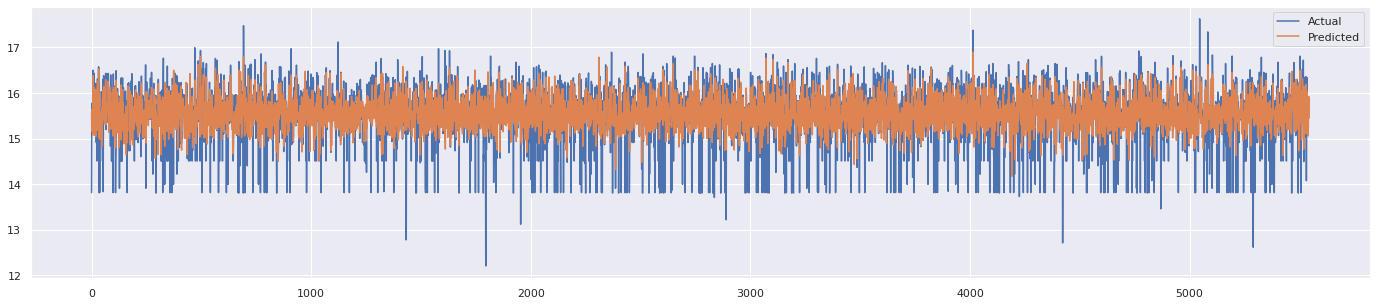

In [553]:
# Predicted Vs Actual (Time Series)
plt.figure(figsize=(24,5))
plt.plot(Y_test.reset_index().index, Y_test, label = "Actual")
plt.plot(Y_test.reset_index().index, Y_pred_rf_hyp_test, label = "Predicted")
plt.legend()
plt.show()

Observations -> Random Forest Regressor (With Default Parameters and Best Parameters)
* Log Normalized the Target Variable

1. Basic RF Regressor and RF Regressor With best params (Used Random Search CV) is used to build model
2. RMSLE -> Basic RF Regressor = 0.0312 (Test)
3. RMSLE -> Hyperparameter tuned RF Regressor = 0.0304 (Test)
4. We Can also Observe that difference between R2 Value for train and test is high(Train High Test Low) for  both models this explains that model didn't generalized well
5. 3. Difference between RMSE (Train & Test) is High (Compared to Linear Regression)


Time Series 

In [554]:
train_data_time_series = train_data.copy()

In [562]:
# Getting Missed Dates
missing_dates = train_data_time_series[['timestamp','price_doc']]
Dates = pd.DatetimeIndex(train_data_time_series['timestamp'])
missing_dates = missing_dates.set_index(Dates).groupby(pd.Grouper(freq = "D")).agg({'price_doc': 'mean'}).reset_index()

In [564]:
# Formatting the Data For Time Series Model
# Converting the Multiple Date Rows Into Single Row for each date using Median For All Columns
# As Time Series Model Needs All the Days Data (No Missing Date Between Min and Max)
# Add Those Rows into the DataFrame and Fill Columns Using Interpolate

train_data_time_series = train_data_time_series.groupby('timestamp').median().reset_index()
train_data_time_series = train_data_time_series.append(pd.DataFrame(missing_dates.loc[missing_dates['price_doc'].isna(), 'timestamp']))
train_data_time_series = train_data_time_series.sort_values(by = ['timestamp'])
train_data_time_series.reset_index(inplace=True, drop=True)
for each_column in train_data_time_series.columns:
  if each_column  != 'timestamp':
    train_data_time_series[each_column] = train_data_time_series[each_column].interpolate()

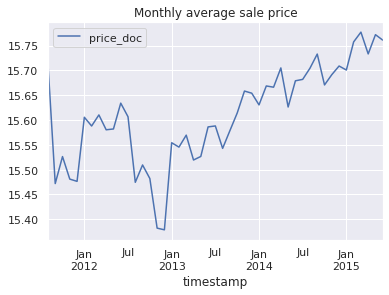

In [565]:
# Dates Vs Average Price (Monthly)
ts = train_data_time_series[['timestamp','price_doc']]
Dates = pd.DatetimeIndex(train_data_time_series['timestamp'])
ts = ts.set_index(Dates).groupby(pd.Grouper(freq = "M")).agg({'price_doc': 'mean'})
ts.plot()
plt.title('Monthly average sale price')
plt.show()

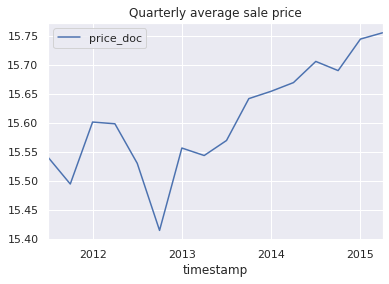

In [566]:
# Dates Vs Average Price (Quarterly)
ts = train_data_time_series[['timestamp','price_doc']]
Dates = pd.DatetimeIndex(train_data_time_series['timestamp'])
ts = ts.set_index(Dates).groupby(pd.Grouper(freq = "Q")).agg({'price_doc': 'mean'})
ts.plot()
plt.title('Quarterly average sale price')
plt.show()

Observation:
1. We Can See that from the Above Graph(Time Stamp Vs Mean Price) There is an Increase in the Mean
2. We Can also observe the seasonality 

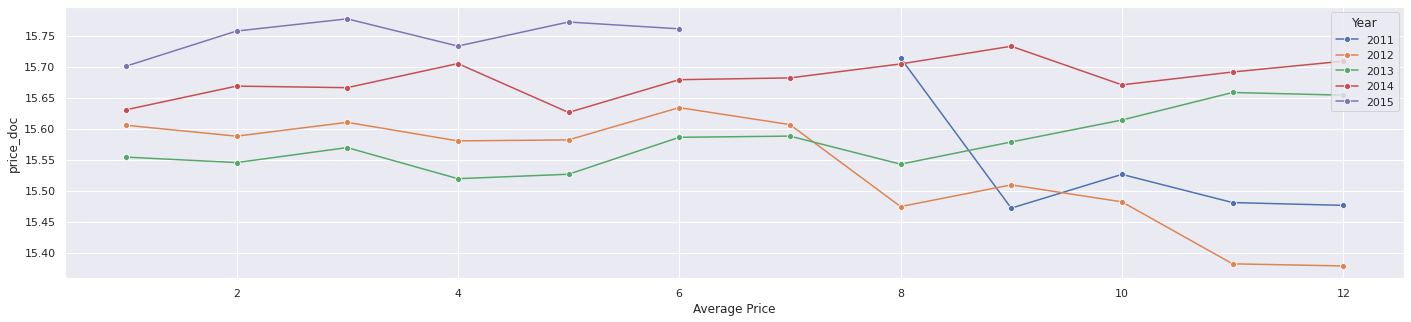

In [567]:
# Years Vs Month Vs Average Price Line Chart
plt.figure(figsize=(24,5))
this_data = train_data_time_series[['timestamp','price_doc']]
this_data['Year'] = pd.DatetimeIndex(this_data['timestamp']).year
this_data['Quarter'] = pd.DatetimeIndex(this_data['timestamp']).quarter
this_data['Month'] = pd.DatetimeIndex(this_data['timestamp']).month
this_data = this_data.groupby(['Year','Month']).agg({'price_doc':'mean'}).reset_index()
for year in this_data.Year.unique():
    data = this_data[this_data.Year == year]
    sns.lineplot(data.Month, data.price_doc, marker='o', label=year)
    plt.legend(title='Year', loc='upper right')
    plt.xlabel('Average Price', fontsize=12)

What is Stationary ?

1.   Stationary  : Don't have trend and Seasonal effects

2.   Non Stationary : Have Trend and Seasonal effects




Trend:  
*   The Value Either Increasing or Decreasing

Seasonality:  
*  Peaks at few particluar Times

We Need to remove Trend or Seasonality From Data If Exists (We Can Use Rolling Mean)

Techniques to identify Trend/Seasonality
1. Plot Graphs and See the Curve
2. Run Some Statistical Tests

In [568]:
# Getting Top Correlated Variables With Target Column
numercial_columns = [each_col for each_col in train_data_time_series.columns if (train_data_time_series[each_col].dtype != 'object') & (each_col not in ['id','timestamp','price_doc'])]

In [569]:
# Calculating the Correlation and Creating the DataFrame (Pearson Correlation)
final_list = []
for each_col in train_data_time_series[numercial_columns].columns:
    results = pearsonr(train_data_time_series[each_col], train_data_time_series['price_doc'])
    corr = results[0]
    p_val = results[1]
    dict_inner = {}
    dict_inner['Column'] = each_col
    dict_inner['Correlation'] = corr
    dict_inner['P-Value'] = p_val
    final_list.append(dict_inner)

In [570]:
# Consider Only Top 10 Feartures For Process
top_10_correlated_features_target = pd.DataFrame(final_list).sort_values(by = ['Correlation'], ascending=False).head(15)
top_10_correlated_features_target_columns = list(top_10_correlated_features_target['Column'].unique())
top_10_correlated_features_target

,Column,Correlation,P-Value
0,full_sq,0.371940,1.583136e-47
1,life_sq,0.327115,1.525814e-36
21,sport_objects_raion,0.280611,6.056250e-27
16,preschool_education_centers_raion,0.225002,1.186559e-17
120,market_count_3000,0.201439,2.198767e-14
25,shopping_centers_raion,0.200441,2.966179e-14
105,cafe_count_1000_price_high,0.197070,8.055346e-14
30,railroad_terminal_raion,0.197070,8.055346e-14
12,raion_popul,0.195410,1.309093e-13
40,build_count_monolith,0.190236,5.784794e-13


In [571]:
# Getting Only Required Columns in the DataFrame
train_data_time_series = train_data_time_series[top_10_correlated_features_target_columns + ['price_doc', 'timestamp']]

In [572]:
# Augmented Dickey-Fuller (For Checking Whether the Series is Stationary Or Not)
def adf_test(timeseries, col_name):
    dftest = adfuller(timeseries, autolag='AIC')
    output = {'test_statistic':round(dftest[0], 4), 'pvalue':round(dftest[1], 4), 'n_lags':round(dftest[2], 4), 'n_obs':dftest[3]}
    if output['pvalue'] <= 0.05:
        return col_name + " is Stationary" + " With P-Values: " + str(round(output['pvalue'],4)) + ", Static Value: " + str(round(output['test_statistic'],4)) 
    else:
        return col_name + " is Not Stationary" + " With P-Values: " + str(round(output['pvalue'],4)) + ", Static Value: " + str(round(output['test_statistic'],4)) 

#apply adf test on the series
for each_column in train_data_time_series.columns:
    if each_column not in ['price_doc', 'timestamp']:
        print(adf_test(train_data_time_series[each_column], each_column))

full_sq is Stationary With P-Values: 0.0, Static Value: -8.4922
life_sq is Stationary With P-Values: 0.0, Static Value: -9.6295
sport_objects_raion is Stationary With P-Values: 0.0, Static Value: -5.822
preschool_education_centers_raion is Stationary With P-Values: 0.0135, Static Value: -3.3323
market_count_3000 is Stationary With P-Values: 0.0076, Static Value: -3.5164
shopping_centers_raion is Stationary With P-Values: 0.0001, Static Value: -4.6231
cafe_count_1000_price_high is Stationary With P-Values: 0.0, Static Value: -16.3309
railroad_terminal_raion is Stationary With P-Values: 0.0, Static Value: -16.3309
raion_popul is Stationary With P-Values: 0.0, Static Value: -5.6391
build_count_monolith is Stationary With P-Values: 0.0, Static Value: -9.4044
office_sqm_500 is Stationary With P-Values: 0.0, Static Value: -23.1671
healthcare_centers_raion is Stationary With P-Values: 0.0067, Static Value: -3.5521
market_count_5000 is Stationary With P-Values: 0.0435, Static Value: -2.916
uni

In [573]:
# Train and Test Data Seperation 
train_data_for_ts = train_data_time_series.copy()
train_data_for_ts = train_data_for_ts.sort_values(by = ['timestamp'])

train_data_for_ts_train = train_data_for_ts.loc[0: train_data_for_ts.shape[0] - int(train_data_for_ts.shape[0]*0.2)-1]
train_data_for_ts_test = train_data_for_ts.loc[train_data_for_ts.shape[0] - int(train_data_for_ts.shape[0]*0.2):]

In [574]:
train_data_for_ts_train.reset_index(drop=True, inplace=True)
train_data_for_ts_test.reset_index(drop=True, inplace=True)

In [575]:
X_Train_ts = train_data_for_ts_train.drop(columns = ['timestamp','price_doc'])
X_Test_ts = train_data_for_ts_test.drop(columns = ['timestamp','price_doc'])

Y_Train_ts = train_data_for_ts_train[['price_doc']]
Y_Test_ts = train_data_for_ts_test[['price_doc']]

In [576]:
X_Train_ts.head(2)

,full_sq,life_sq,sport_objects_raion,preschool_education_centers_raion,market_count_3000,shopping_centers_raion,cafe_count_1000_price_high,railroad_terminal_raion,raion_popul,build_count_monolith,office_sqm_500,healthcare_centers_raion,market_count_5000,university_top_20_raion,trc_sqm_3000
0,43.0,27.000000,7.000000,5.0,1.0,16.000000,0.0,0.0,155572.000000,2.000000,0.0,1.0,4.000000,0.0,1419204.0
1,40.0,24.333333,6.666667,5.0,1.0,11.666667,0.0,0.0,142165.333333,2.666667,0.0,1.0,7.333333,0.0,1109991.0


In [577]:
X_Test_ts.head(2)

,full_sq,life_sq,sport_objects_raion,preschool_education_centers_raion,market_count_3000,shopping_centers_raion,cafe_count_1000_price_high,railroad_terminal_raion,raion_popul,build_count_monolith,office_sqm_500,healthcare_centers_raion,market_count_5000,university_top_20_raion,trc_sqm_3000
0,47.0,29.0,4.0,4.0,2.0,4.0,0.0,0.0,81980.0,7.0,0.0,1.0,6.0,0.0,427350.0
1,48.5,29.0,4.5,4.0,2.0,2.0,0.0,0.0,77274.0,6.0,0.0,1.0,5.0,0.0,243532.5



Difference between ARIMA, SARIMA, SARIMAX
1.   ARIMA -> Auto-Regressive Integrated Moving Average
2.   SARIMA -> Seasonal Auto-Regressive Integrated Moving Average
3.   SARIMAX -> Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (variables whose cause is external to the model or Domain Specific Features)


Paramaters For SARIMAX Model
*  p = non-seasonal autoregressive (AR)
*   d = non-seasonal differencing or Integrative Part (I)
*   q= non-seasonal moving average (MA) 

*   P = seasonal AR order
*   D = seasonal differencing or Integrative Part
*   Q = seasonal MA order

*   S = length of repeating seasonal pattern

In [578]:
# Error Percentage (Mean Absolute Percentage Error)
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [579]:
sarimax_lowest_mse = []

In [580]:
#inputs fgi and ocf
def arimax_parameters(all_param, y_train, X_train, y_test, X_test):
    global sarimax_lowest_mse
    for param in all_param:
        sarimax_results = {}

        model = sm.tsa.statespace.SARIMAX(y_train, exog = X_train, order = param[0], seasonal_order = param[1], enforce_stationarity=False, enforce_invertibility=False)
        model = model.fit(low_memory=True, disp=0)
        forecast = model.forecast(steps=len(X_test), exog= X_test).values
        
        try:
          sarimax_results["Non-SeasonalParameters"] = str(param[0])
          sarimax_results["SeasonalParameters"] = str(param[1])
          sarimax_results["Actual"] = y_test.values
          sarimax_results["Predicted"] = forecast
          sarimax_results["MAPE"] = MAPE(y_test, forecast)
          sarimax_results["MAE"] = mean_absolute_error(y_test, forecast)
          sarimax_results["MSE"] = mean_squared_error(y_test, forecast)
          sarimax_results["RMSE"] = np.sqrt(mean_squared_error(y_test, forecast))
          sarimax_results["RMSLE"] = np.sqrt(mean_squared_log_error(y_test, forecast))
        except Exception as exe:
            print("Error")
            print(str(exe))
        sarimax_lowest_mse.append(sarimax_results)
        try:
          del model, forecast
        except Exception as exe:
          print(str(exe))
    return sarimax_lowest_mse

In [581]:
# Combination Of Parameter Tried 
p = q = [0,1,2]
d = [1]

P = Q = [0,1,2]
D = [1]
s = [7]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

# Fit Multple Parameters To Get Best Parameters
peak_parameters = arimax_parameters(all_param[20:], Y_Train_ts, X_Train_ts, Y_Test_ts, X_Test_ts)

In [394]:
# results_df = pd.DataFrame(sarimax_lowest_mse)
# results_df = results_df.sort_values(by = ['MAPE'])
# results_df.to_excel("Results_Analysis.xlsx")

In [582]:
# Best Params (Decided Based On MAPE Error (Less MAPE Error Better Model))
p = 0
d = 1
q = 2

P = D = 1
Q = 2
s = 7

In [583]:
# Build SARIMAX Model With Best Parameters
Model_4_SARIMAX = sm.tsa.statespace.SARIMAX(Y_Train_ts, exog = X_Train_ts, order = (p,d,q), seasonal_order = (p,d,q,s), enforce_stationarity=False, enforce_invertibility=False)
Model_4_SARIMAX = Model_4_SARIMAX.fit(disp=0)

In [584]:
predicted_values = Model_4_SARIMAX.forecast(steps=len(X_Test_ts), exog=X_Test_ts).values

In [589]:
print("MAPE: ", MAPE(Y_Test_ts, predicted_values))
print("MAE: ",mean_absolute_error(Y_Test_ts, predicted_values))
print("MSE: ",mean_squared_error(Y_Test_ts, predicted_values))
print("RMSE: ",np.sqrt(mean_squared_error(Y_Test_ts, predicted_values)))
print("RMSLE: ",np.sqrt(mean_squared_log_error(Y_Test_ts, predicted_values)))

MAPE:  0.845460974505018
MAE:  0.08854266743513917
MSE:  0.013731832628790647
RMSE:  0.1171829024593206
RMSLE:  0.006992566192799172


In [585]:
Actual_predicted_results = Y_Test_ts.copy()
Actual_predicted_results['Predicted_price_doc']  = predicted_values

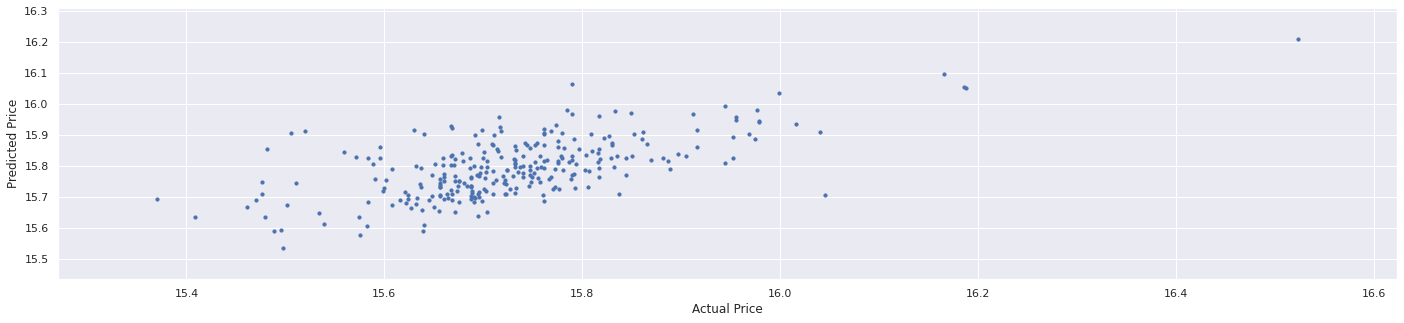

In [586]:
# Predicted Vs Actual (Time Series)
plt.figure(figsize=(24,5))
plt.scatter(x = Actual_predicted_results['price_doc'].values, y = Actual_predicted_results['Predicted_price_doc'], s = 10, cmap = 'viridis')
plt.plot([0,9],[0,9],'k-', lw = 2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.xlim([min(min(Actual_predicted_results['price_doc']), min(Actual_predicted_results['price_doc']))-0.1, \
          max(max(Actual_predicted_results['price_doc']), max(Actual_predicted_results['price_doc']))+0.1])
plt.ylim([min(min(Actual_predicted_results['Predicted_price_doc']), min(Actual_predicted_results['Predicted_price_doc']))-0.1, \
          max(max(Actual_predicted_results['Predicted_price_doc']), max(Actual_predicted_results['Predicted_price_doc']))+0.1])
plt.show()

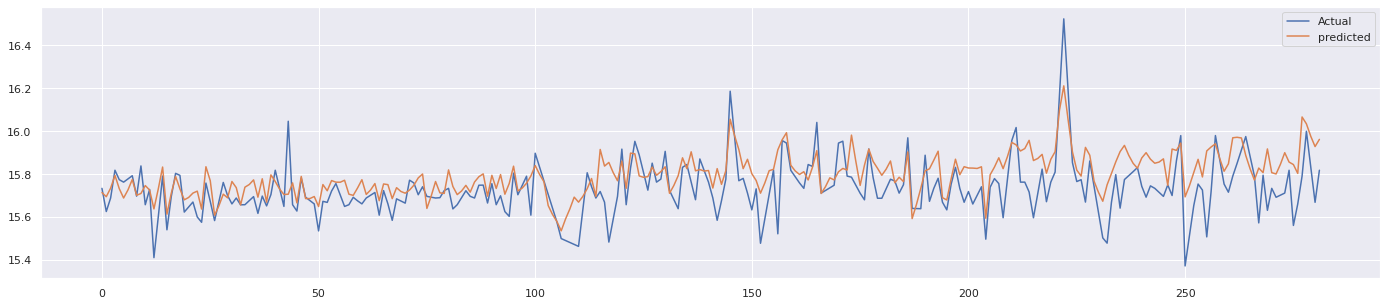

In [588]:
# Predicted Vs Actual (Time Series)
plt.figure(figsize=(24,5))
plt.plot(Actual_predicted_results.index, Actual_predicted_results['price_doc'], label = "Actual")
plt.plot(Actual_predicted_results.index, Actual_predicted_results['Predicted_price_doc'], label = "predicted")
plt.legend()
plt.show()

Time Series Model Overview:
1. Tried Different Combinations Of Parameters (Both Seasonal and Non Seasonal)
2. Best Params are consdiered based on MAPE(Mean Absolute Percentage Error)
  * Seasonal -> P = 1 D = 1 Q = 2
  * Non Seasonal -> p = 0 d = 1 q = 2
  * Lenght of repeated seasonal pattern  -> s = 7
3. MAPE For Best Model = 0.84
4. Overall Model able to identify the price trend with some error (MAE : 0.08)